In [47]:
import numpy as np

import cv2

import torch
from torch.nn import functional as F
from torchvision.transforms.functional import to_tensor

from models.unet_mini import UNetMini
from dataset.utils import show_array
from dataset.synthetic_card_image_dataset import SyntheticCardImageDataset


def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


class ModelInference():
    IMG_SIZE = 512
    
    def __init__(self, weights_path):
        self._model = UNetMini(2)
        state_dict = torch.load(weights_path)
        self._model.load_state_dict(state_dict)
        
    def predict(self, img):
        img = self.preprocess_image(img)
        with torch.no_grad():
            img = to_tensor(img)
            img = img[None, :]
            output = self._model(img)
            output = F.softmax(output, dim=1)
        img_mask = output[0, 1].cpu().numpy()
        img_mask *= 255
        img_mask = img_mask.astype(np.uint8)
        return img_mask
        
    @staticmethod
    def preprocess_image(img):
        img = img.copy()

        if img.shape[0] != img.shape[1]:
            size = max(img.shape)
            new_img = np.zeros([size] * 2, dtype=np.uint8)
            y_delta, x_delta = ((size - np.array(img.shape)) / 2).astype(np.int)    
            new_img[y_delta:img.shape[0] + y_delta, x_delta:img.shape[1] + x_delta] = img
            img = new_img

        img = cv2.resize(img, tuple([ModelInference.IMG_SIZE]*2))

        return img


def predict_and_show(img):    

    show_array(img)

    img_pred = model_inference.predict(img)

    show_array(img_pred)

In [48]:
model_inference = ModelInference('./artifacts/baseline2/epoch_model_150.pth')

### Samples from training domain

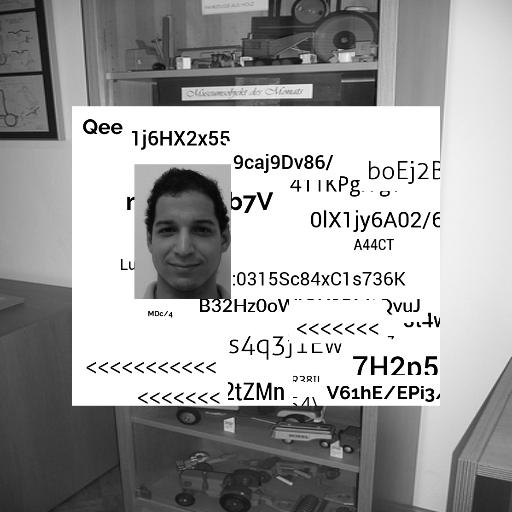

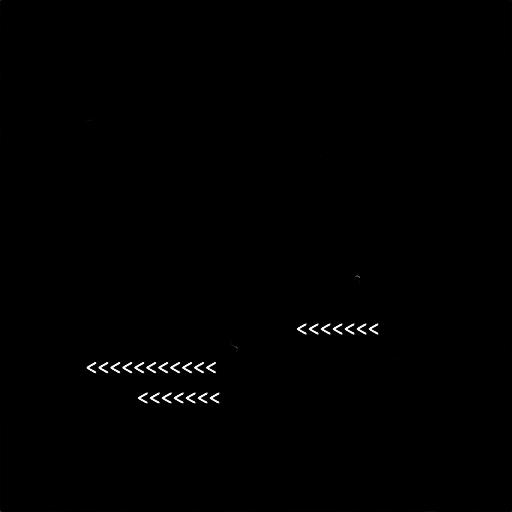

In [54]:
dataset = SyntheticCardImageDataset(512, to_tensor=False)

img, _ = dataset[0]
img = np.array(img)
predict_and_show(img)

### Simple real sample

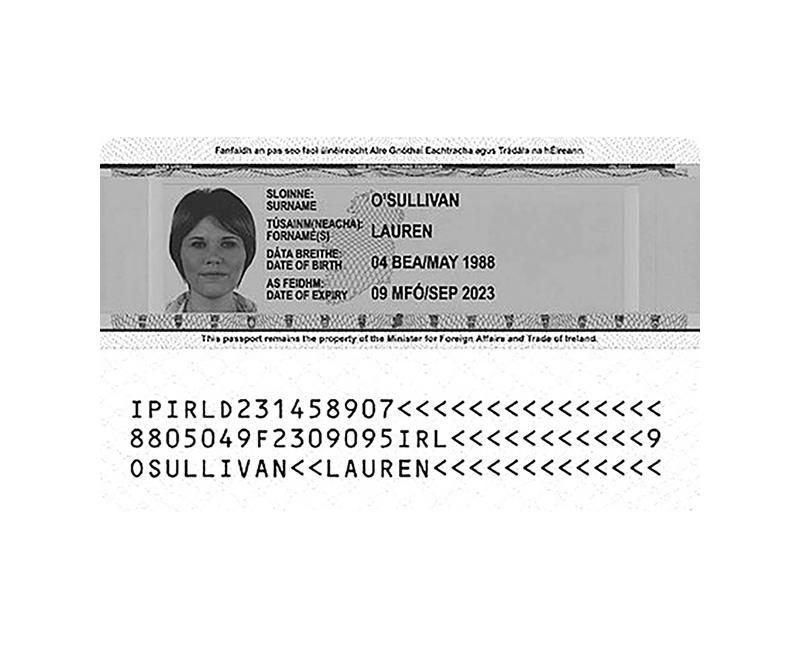

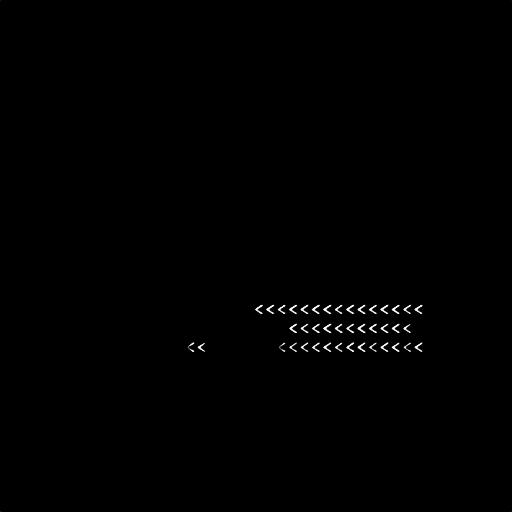

In [55]:
img_path = './problem_statement/sample6.jpg'
img = load_image(img_path)
predict_and_show(img)

### Normal real sample

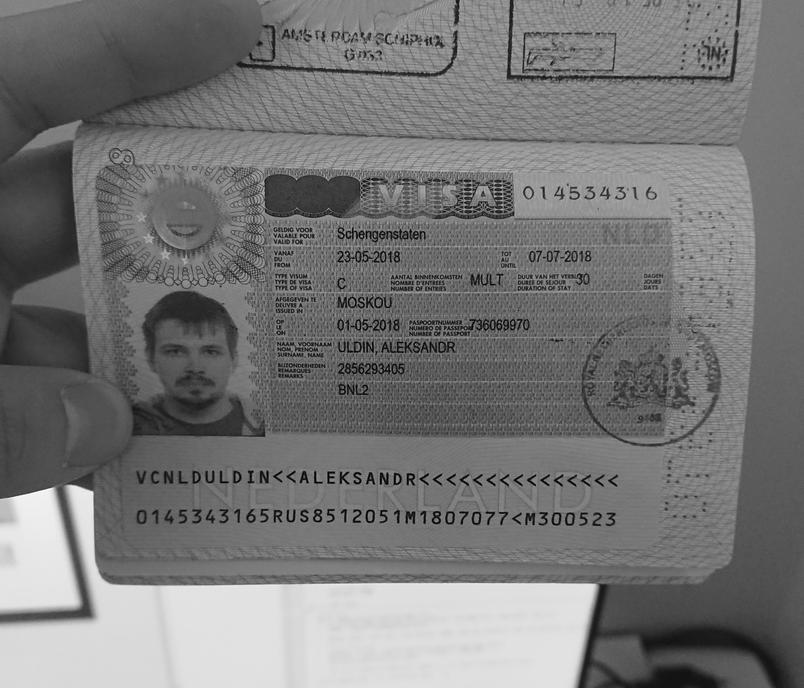

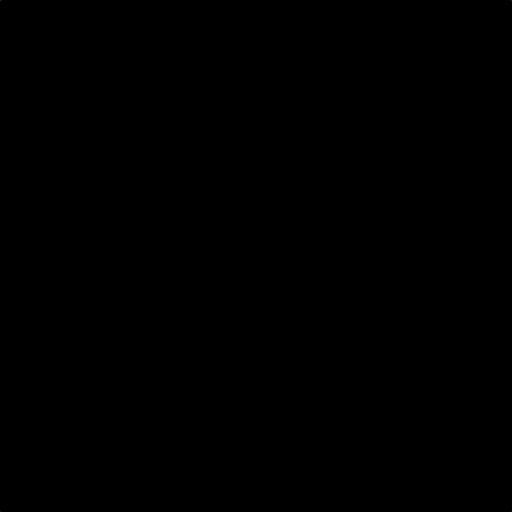

In [57]:
img_path = './demo/images/normal.png'
img = load_image(img_path)
predict_and_show(img)